In [1]:
import tensorflow as tf
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import numpy as np
x1 = np.load('dataset/LSTM_x1.npy')

In [3]:
x2 = np.load('dataset/LSTM_x2.npy')

In [4]:
y = np.load('dataset/LSTM_y.npy')

In [5]:
print(x1.shape)
print(x2.shape)
print(y.shape)

(3120, 16, 96, 128, 3)
(3120, 16, 96, 128, 3)
(3120, 16, 96, 128, 4)


In [6]:
from sklearn.utils import shuffle

x1, x2, y = shuffle(x1, x2, y, random_state=42)

In [7]:
x1_train = x1[:len(x1)//10*7]
x1_val = x1[len(x1)//10*7:len(x1)//10*7+len(x1)//10*2]
x1_test = x1[len(x1)//10*7+len(x1)//10*2:len(x1)]
del x1

x2_train = x2[:len(x2)//10*7]
x2_val = x2[len(x2)//10*7:len(x2)//10*7+len(x2)//10*2]
x2_test = x2[len(x2)//10*7+len(x2)//10*2:len(x2)]
del x2

y_train = y[:len(y)//10*7]/255
y_val = y[len(y)//10*7:len(y)//10*7+len(y)//10*2]
y_test = y[len(y)//10*7+len(y)//10*2:len(y)]
del y

In [8]:
class My_Custom_Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, image_filenames_1, image_filenames_2, labels, batch_size) :
    self.image_filenames1 = image_filenames_1
    self.image_filenames2 = image_filenames_2
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames1) / float(self.batch_size))).astype('uint8')
  
  
  def __getitem__(self, idx) :
    batch_x1 = self.image_filenames1[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_x2 = self.image_filenames2[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    return [np.array(batch_x1)/255,np.array(batch_x2)/255], np.array(batch_y)

In [9]:
batch_size = 1

train = My_Custom_Generator(x1_train, x2_train, y_train, batch_size)
validation = My_Custom_Generator(x1_val, x2_val, y_val, batch_size)

In [10]:
class MyModel():

    def __init__(self):
        '''
        Crear el modelos para segmentación
        '''
        self.input_rgb = tf.keras.layers.Input(shape=(16,96,128,3),dtype=tf.float32,name='input_1')
        self.input_depth = tf.keras.layers.Input(shape=(16,96,128,3),dtype=tf.float32,name='input_2')
        self.fusion_1 = None
        self.fusion_2 = None
#         self.fusion_3 = None

    def rgbd_fusion(self,input_r,input_d,capa):
        r = tf.keras.layers.GlobalAveragePooling3D()(input_r)
        r = tf.keras.layers.Reshape((1,1,1,64*capa))(r)
        r = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(4*capa,kernel_size=(1,1),strides=(1,1),activation='relu'))(r)
        r = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64*capa,kernel_size=(1,1),strides=(1,1),activation='sigmoid'))(r)
        m_1 = tf.keras.layers.Multiply()([input_r,r])
        
        d = tf.keras.layers.GlobalAveragePooling3D()(input_d)
        d = tf.keras.layers.Reshape((1,1,1,64*capa))(d)
        d = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(4*capa,kernel_size=(1,1),strides=(1,1),activation='relu'))(d)
        d = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64*capa,kernel_size=(1,1),strides=(1,1),activation='sigmoid'))(d)
        m_2 = tf.keras.layers.Multiply()([input_d,d])
        
        return tf.keras.layers.Add()([m_1,m_2])

    def resnet_layer(self,input_res, input_add, filters):
        x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters, (3,3), padding='same'))(input_res)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters, (3,3), padding='same'))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters, (3,3), padding='same'))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters, (3,3), padding='same'))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Add()([input_add,x])
        x = tf.keras.layers.Activation('relu')(x)
        
        return x
    
    def resnet_layer_div(self,input_res, input_add, filters):
        x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters, (3,1), padding='same', strides=(2,1)))(input_res)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        
        x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters, (1,3), padding='same', strides=(1,2)))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters, (3,1), padding='same'))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters, (1,3), padding='same'))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Add()([input_add,x])
        x = tf.keras.layers.Activation('relu')(x)

        return x
    
    def bottleneck_layer(self,input_bo,filters):
        x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters, kernel_size=(3,1), activation='relu', padding='same'))(input_bo)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters, kernel_size=(1,3), activation='relu', padding='same'))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters, kernel_size=(3,1), activation='relu', padding='same'))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters, kernel_size=(1,3), activation='relu', padding='same'))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Add()([x, input_bo])
        x = tf.keras.layers.Activation('relu')(x)
        return x

    def decode_layer(self,input_de,input_add,filters):
        x = tf.keras.layers.BatchNormalization()(input_de)
        x = tf.keras.layers.ConvLSTM2D(filters,kernel_size=(3,3),activation='sigmoid', padding='same', return_sequences=True)(x)
        x = self.bottleneck_layer(x, filters)
        x = self.bottleneck_layer(x, filters)
        x = self.bottleneck_layer(x, filters)
        x = tf.keras.layers.UpSampling3D(size=(1,2,2))(x)
        x_2 = tf.keras.layers.BatchNormalization()(input_add)
        x_2 = tf.keras.layers.ConvLSTM2D(filters, kernel_size=(3,3), activation='sigmoid', padding='same', return_sequences=True)(x_2)
        x = tf.keras.layers.Add()([x, x_2])
        return x
        
    def model(self):

        # Preparar la entrada de datos
        xr = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides=(2,2),padding='same',dilation_rate=(1,1),activation='relu'))(self.input_rgb)
        xd = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides=(2,2),padding='same',dilation_rate=(1,1),activation='relu'))(self.input_depth)

        # Fusion
        xd = self.rgbd_fusion(xr,xd,1)

        # Preparar para encoder
        xr = tf.keras.layers.MaxPool3D(pool_size=(1,3,3), strides=(1,2,2), padding='same')(xr)
        xd = tf.keras.layers.MaxPool3D(pool_size=(1,3,3), strides=(1,2,2), padding='same')(xd)

        ''' ENCODER'''
        # PRIMERA CAPA
        n = 3 # las veces que se repite el resnet_layer
        for k in range(n):
            xr = self.resnet_layer(xr,xr,64)
            xd = self.resnet_layer(xd,xd,64)
            
        # Fusion despues de Resnet
        xd = self.rgbd_fusion(xr,xd,1)
        self.fusion_1 = xd  # Aqui guardamos la fusion realizada despues de la capa resnet. Esto lo utilizaremos para decodificar.

        # SEGUNDA CAPA
        xr = self.resnet_layer_div(xr,tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(128,kernel_size=(1,1),strides=(2,2)))(xr),128)
        xd = self.resnet_layer_div(xd,tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(128,kernel_size=(1,1),strides=(2,2)))(xd),128)

        n = 3 # las veces que se repite el resnet_layer
        for k in range(n):
            xr = self.resnet_layer(xr,xr,128)
            xd = self.resnet_layer(xd,xd,128)
            
        # Fusion despues de Resnet
        xd = self.rgbd_fusion(xr,xd,2)
        self.fusion_2 = xd
        
        # TERCERA CAPA
        xr = self.resnet_layer_div(xr,tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(256,kernel_size=(1,1),strides=(2,2)))(xr),256)
        xd = self.resnet_layer_div(xd,tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(256,kernel_size=(1,1),strides=(2,2)))(xd),256)

            
        n = 3 # las veces que se repite el resnet_layer
        for k in range(n):
            xr = self.resnet_layer(xr,xr,256)
            xd = self.resnet_layer(xd,xd,256)
            
        # Fusion despues de Resnet
        xd = self.rgbd_fusion(xr,xd,4)
        self.fusion_3 = xd  # Aqui guardamos la fusion realizada despues de la capa resnet. Esto lo utilizaremos para decodificar.

        # CUARTA CAPA
        xr = self.resnet_layer_div(xr,tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(512,kernel_size=(1,1),strides=(2,2)))(xr),512)
        xd = self.resnet_layer_div(xd,tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(512,kernel_size=(1,1),strides=(2,2)))(xd),512)
            
        # Fusion despues de Resnet
        xr = self.rgbd_fusion(xr,xd,8)

        '''DECODER'''

        xr = self.decode_layer(xr,self.fusion_3,128)
        xr = self.decode_layer(xr,self.fusion_2,128)
        xr = self.decode_layer(xr,self.fusion_1,64)
        
        xr = tf.keras.layers.ConvLSTM2D(32, kernel_size=(3,3), activation='sigmoid', padding='same', return_sequences=True)(xr)
        xr = tf.keras.layers.BatchNormalization()(xr)
        xr = tf.keras.layers.UpSampling3D(size=(1,2,2))(xr)
        xr = tf.keras.layers.ConvLSTM2D(32, kernel_size=(2,2), activation='sigmoid', padding='same', return_sequences=True)(xr)
        xr = tf.keras.layers.BatchNormalization()(xr)
        xr = tf.keras.layers.UpSampling3D(size=(1,2,2))(xr)
        xr = tf.keras.layers.ConvLSTM2D(4, kernel_size=(1,1), activation='softmax', padding='same', return_sequences=True)(xr)

        return tf.keras.Model(inputs=[self.input_rgb, self.input_depth], outputs=xr)

In [11]:
model = MyModel().model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16, 96, 128, 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 16, 96, 128, 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 16, 48, 64, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 16, 48, 64, 6 1792        input_2[0][0]                    
______________________________________________________________________________________________

In [12]:
tf.keras.utils.plot_model(model,to_file="model.png")

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [13]:
import matplotlib.pyplot as plt
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

In [14]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import math
weight_path="{}_best_weights.hdf5".format('seg_LSTM_fusion_model_2')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, min_delta=0.0001, cooldown=2, min_lr=1e-6)

def step_decay(epoch, lr):
    decay_rate = 0.5
    decay_step = 2
    if epoch % decay_step == 0 and epoch and lr>1e-9:
        return lr * decay_rate
    return lr

lrate = LearningRateScheduler(step_decay)

early = EarlyStopping(monitor="val_loss",
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, lrate]

In [15]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5, amsgrad=True, name="Adam")

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train, epochs=1000, verbose=1, steps_per_epoch=64,
                    validation_data=validation, callbacks=callbacks_list)

Epoch 1/1000
64/64 [==============================] - 196s 2s/step - loss: 0.0322 - accuracy: 0.2930 - val_loss: 0.6545 - val_accuracy: 0.0046

Epoch 00001: val_loss improved from inf to 0.65448, saving model to seg_LSTM_fusion_model_2_best_weights.hdf5
Epoch 2/1000
64/64 [==============================] - 152s 2s/step - loss: 0.0116 - accuracy: 0.2525 - val_loss: 0.6472 - val_accuracy: 0.1442

Epoch 00002: val_loss improved from 0.65448 to 0.64719, saving model to seg_LSTM_fusion_model_2_best_weights.hdf5
Epoch 3/1000
64/64 [==============================] - 149s 2s/step - loss: 0.0100 - accuracy: 0.2800 - val_loss: 0.6287 - val_accuracy: 0.4980

Epoch 00003: val_loss improved from 0.64719 to 0.62872, saving model to seg_LSTM_fusion_model_2_best_weights.hdf5
Epoch 4/1000
64/64 [==============================] - 148s 2s/step - loss: 0.0093 - accuracy: 0.3368 - val_loss: 0.8788 - val_accuracy: 0.2868

Epoch 00004: val_loss did not improve from 0.62872
Epoch 5/1000
64/64 [===============

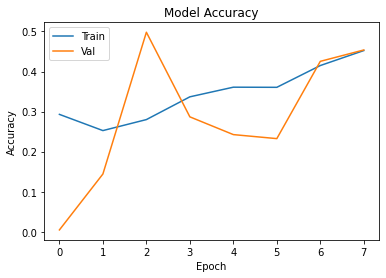

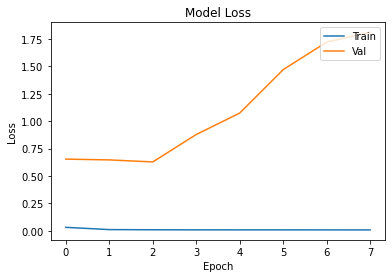

In [16]:
plot_acc(history)
plot_loss(history)

In [17]:
batch_size = 1

test = My_Custom_Generator(x1_test, x2_test, y_test, batch_size)

In [18]:
score = model.evaluate(test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 1.8486508131027222
Test accuracy: 0.43241629004478455


In [19]:
model.load_weights('seg_LSTM_fusion_model_2_best_weights.hdf5')

In [20]:
class Test_Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, image_filenames_1, image_filenames_2, batch_size) :
    self.image_filenames1 = image_filenames_1
    self.image_filenames2 = image_filenames_2
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames1) / float(self.batch_size))).astype('uint32')
  
  
  def __getitem__(self, idx) :
    batch_x1 = self.image_filenames1[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_x2 = self.image_filenames2[idx * self.batch_size : (idx+1) * self.batch_size]
    
    return [np.array(batch_x1)/255,np.array(batch_x2)/255]

In [21]:
batch_size = 1

x_predict = Test_Generator(x1_test, x2_test, batch_size)

In [22]:
y_pred = np.asarray([model.predict(p) for p in x_predict])
y_classes = np.asarray([np.argmax(y, axis=-1) for y in y_pred])
label = np.asarray([np.argmax(y, axis=-1) for y in y_test])

In [30]:
predicted_arr = np.asarray([y_classes[i][0] for i in range(len(y_classes))])

In [38]:
predicted_arr[0][0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [24]:
import matplotlib.pyplot as plt

def plot_color(ax, color, title="Color"):
    """Displays a color image from the dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(color)

def plot_depth(ax, depth, title="Depth"):
    """Displays a depth map from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(depth, cmap='Spectral')

def plot_label(ax, labels, title="Label"):
    """Displays a label map from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(labels)

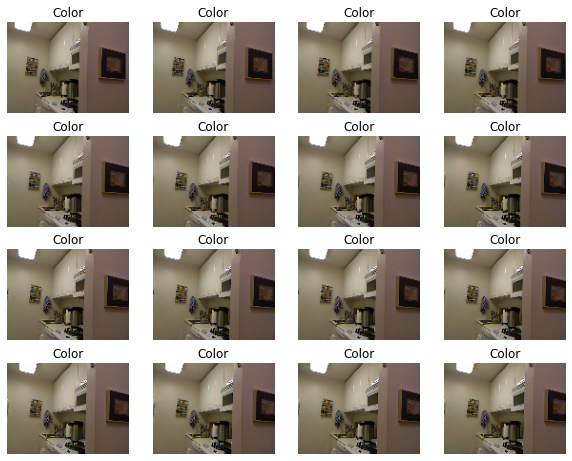

In [47]:
numero = 10

fig = plt.figure("Labeled Dataset Sample", figsize=(10, 8))

for n in range(len(x1_test[1])):
    
    ax = fig.add_subplot(4, 4, n+1)
    plot_color(ax, x1_test[numero][n]/255)

plt.show()

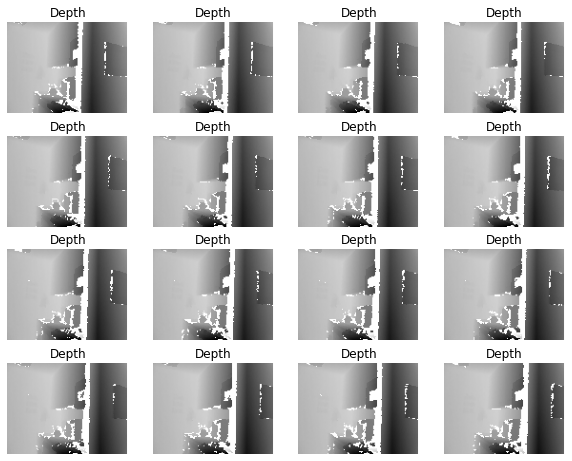

In [48]:
fig = plt.figure("Labeled Dataset Sample", figsize=(10, 8))
for n in range(len(x2_test[1])):
    ax = fig.add_subplot(4, 4, n+1)
    plot_depth(ax, x2_test[numero][n]/255)
plt.show()

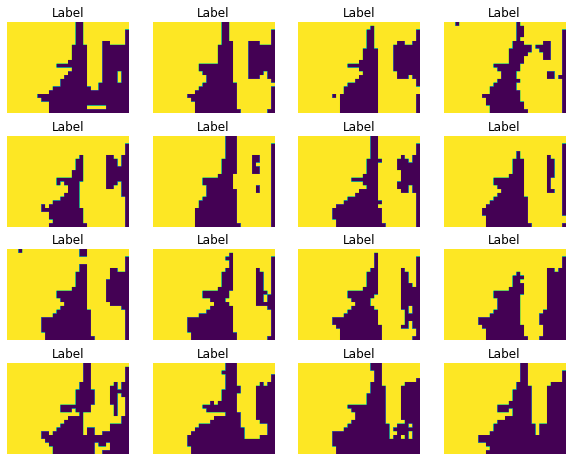

In [49]:
fig = plt.figure("Labeled Dataset Sample", figsize=(10, 8))
for n in range(len(label[0])):
    ax = fig.add_subplot(4, 4, n+1)
    plot_label(ax, label[numero][n])
plt.show()

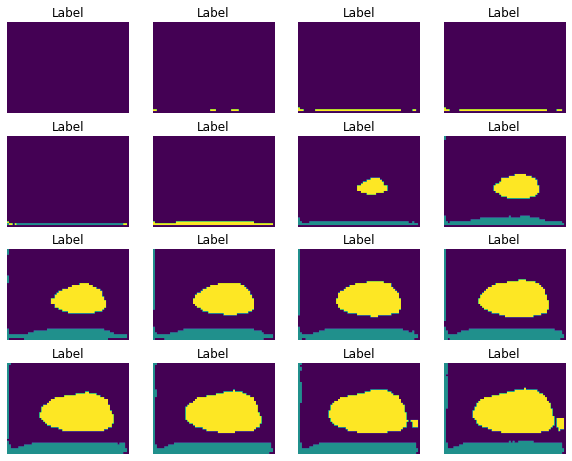

In [50]:
fig = plt.figure("Labeled Dataset Sample", figsize=(10, 8))
for n in range(len(y_classes[0][0])):
    ax = fig.add_subplot(4, 4, n+1)
    plot_label(ax,y_classes[numero][0][n])
plt.show()

In [44]:
Precision = tf.keras.metrics.Precision()
Precision.update_state(label[:50],predicted_arr[:50])
precision = Precision.result().numpy()
Recall = tf.keras.metrics.Recall()
Recall.update_state(label[:50],predicted_arr[:50])
recall = Recall.result().numpy()

print('Recall: ', recall)
print('Precision: ', precision)

InvalidArgumentError: predictions must be <= 1
Condition x <= y did not hold.
First 3 elements of x:
[0. 0. 0.]
First 1 elements of y:
[1.]